## policy optimization and evaluation

In [1]:
suppressWarnings(suppressMessages(library(tidyverse)))
suppressWarnings(suppressMessages(library(caret)))
suppressWarnings(suppressMessages(library(mlr)))
suppressWarnings(suppressMessages(library(boot)))

In [2]:
sessionInfo()

R version 4.1.1 (2021-08-10)
Platform: x86_64-conda-linux-gnu (64-bit)
Running under: Red Hat Enterprise Linux

Matrix products: default
BLAS/LAPACK: /usr/local/app/rcs_bin/grid3/envs/rcs_2022.01/lib/libmkl_rt.so.1

locale:
 [1] LC_CTYPE=en_US.UTF-8       LC_NUMERIC=C              
 [3] LC_TIME=en_US.UTF-8        LC_COLLATE=en_US.UTF-8    
 [5] LC_MONETARY=en_US.UTF-8    LC_MESSAGES=en_US.UTF-8   
 [7] LC_PAPER=en_US.UTF-8       LC_NAME=C                 
 [9] LC_ADDRESS=C               LC_TELEPHONE=C            
[11] LC_MEASUREMENT=en_US.UTF-8 LC_IDENTIFICATION=C       

attached base packages:
[1] stats     graphics  grDevices utils     datasets  methods   base     

other attached packages:
 [1] boot_1.3-28       mlr_2.19.0        ParamHelpers_1.14 caret_6.0-90     
 [5] lattice_0.20-45   forcats_0.5.1     stringr_1.4.0     dplyr_1.0.7      
 [9] purrr_0.3.4       readr_2.1.2       tidyr_1.2.0       tibble_3.1.6     
[13] ggplot2_3.3.5     tidyverse_1.3.1  

loaded via a namespace (

In [3]:
dir_path = '/export/projects2/jeryang_narrative_project/globe/log'
setwd(dir_path)

In [4]:
set.seed(101)

### first experiment

In [5]:
df1 = read.csv('./df_exp1.csv')
df1_s = read.csv('./df_surrogate_exp1.csv')

df1 = arrange(df1, subscriber_id)
df1_s = arrange(df1_s, subscriber_id)

In [6]:
# policy optimization
optimize_binary_policy <- function(mu, # load predicted outcomes, see details of estimating an outcome model via cross-fitting in cross_fitting.ipynb 
                            df_x, # load data with pre-treatment covariates
                            df_s, # load data with surrogates and outcomes
                            id, # id to match the data with
                            outcome, # specify which outcome to use to optimize the policy 
                            train_id){ # vector of row numbers used in training 
                                   

mu = left_join(mu,select(df_x,all_of(id),p_treated,risk_score,treated), by = id)
mu = left_join(mu,select(df_s,all_of(id),all_of(outcome)), by = id)
mu = rename(mu,rev = all_of(outcome))
mu = arrange(mu, id)

# construct doubly robust scores
mu$y0_dr = ifelse(mu$treated == 1, mu$y0, mu$y0 + (mu$rev - mu$y0)/(1-mu$p_treated))
mu$y1_dr = ifelse(mu$treated == 0, mu$y1, mu$y1 + (mu$rev - mu$y1)/(mu$p_treated))
mu$tau_dr = mu$y1_dr - mu$y0_dr
    
# construct misclassification cost
cost = data.frame(control = rep(0,nrow(mu)), treat = rep(0,nrow(mu)))
cost$control = ifelse(mu$tau_dr < 0,0,abs(mu$tau_dr))
cost$treat = ifelse(mu$tau_dr > 0,0,abs(mu$tau_dr))

# convert covariates into model matrix
df_x = arrange(df_x, id)
df_X = select(df_x,-regi_user_key,-treated,-last_stop_date,
              -churn,-time,-rev,-rev1,-rev2,-rev3,-subscription_status)
df_X = model.matrix(~.-1, df_X) %>% as.data.frame
colnames(df_X) = paste0('col',seq(1,ncol(df_X)))

# specify cost-sensitive classifier
obp = makeCostSensTask(id = "binary-action policy learning", 
                       data = df_X[train_id,], 
                       cost = cost[train_id,])

# specify learner with pre-tuned hyperparameters 
learner = makeLearner("classif.xgboost",
                      predict.type = "prob",
                      eval_metric = 'logloss',
                      eta = 0.3,
                      max_depth = 6,
                      gamma = 0,
                      colsample_bytree = 0.6,
                      min_child_weight = 1,
                      subsample = 1,
                      nrounds = 150)
learner = makeCostSensWeightedPairsWrapper(learner)

# train the classifier
obp = mlr::train(learner, obp)

return(obp)

}

In [7]:
# use 18-month true revenue for policy evaluation
mu_eval = read.csv('mu_18m_true.csv')
mu_eval = arrange(mu_eval, subscriber_id)

mu_eval = left_join(mu_eval,select(df1,subscriber_id,p_treated,risk_score,treated), by = 'subscriber_id')
mu_eval = left_join(mu_eval,select(df1_s,subscriber_id,rev), by = 'subscriber_id')

mu_eval = rename(mu_eval, rev = rev)

mu_eval$y0_dr = ifelse(mu_eval$treated == 1, mu_eval$y0, mu_eval$y0 + (mu_eval$rev - mu_eval$y0)/(1-mu_eval$p_treated))
mu_eval$y1_dr = ifelse(mu_eval$treated == 0, mu_eval$y1, mu_eval$y1 + (mu_eval$rev - mu_eval$y1)/(mu_eval$p_treated))

mu_eval$tau_dr = mu_eval$y1_dr - mu_eval$y0_dr

In [8]:
# convert covariates into model matrix for prediction
df_X = select(df1,-regi_user_key,-treated,-last_stop_date,
              -churn,-time,-rev,-rev1,-rev2,-rev3,-subscription_status)
df_X = model.matrix(~.-1, df_X) %>% as.data.frame
colnames(df_X) = paste0('col',seq(1,ncol(df_X)))

In [9]:
# split training and test data, test data will be used in policy evaluation
train_id = sort(sample(nrow(df_X), nrow(df_X)*0.8))

In [10]:
test = cbind(df_X[-train_id,], mu_eval[-train_id,])

In [11]:
# compare a policy with a benchmark policy that treats no one
policy_eval_benchmark <- function(test,indices) {
  
  test_b = test[indices,]

  test_b$p_no_one = ifelse(test_b$treated==1, 0, 1)
  test_b$p_design = ifelse(test_b$treated==1, test_b$p_treated, 1-test_b$p_treated)
    
  test_b$p_dr = ifelse(test_b$response == 'treat',test_b$treated,1-test_b$treated) 
  test_b$p_dr_treat <- ifelse(test_b$response == 'treat',1,0)
    
  rev_no_one = with(test_b, mean(y0 + 
                             p_no_one/p_design*(rev - (y1*treated + y0*(1-treated)))))   

  rev_dr = with(test_b, mean(y1*p_dr_treat + y0*(1-p_dr_treat) + 
                             p_dr/p_design*(rev - (y1*treated + y0*(1-treated)))))
  
  return(c(rev_dr - rev_no_one))
    
}

In [12]:
# compare a policy with a policy optimized on true 18-month revenue
policy_eval_true <- function(test,indices) {
  
  test_b = test[indices,]

  test_b$p_design = ifelse(test_b$treated==1, test_b$p_treated, 1-test_b$p_treated)
    
  test_b$p_dr = ifelse(test_b$response == 'treat',test_b$treated,1-test_b$treated) 
  test_b$p_dr_treat <- ifelse(test_b$response == 'treat',1,0)
    
  test_b$p_dr_true = ifelse(test_b$response_true == 'treat',test_b$treated,1-test_b$treated)  
  test_b$p_dr_treat_true <- ifelse(test_b$response_true == 'treat',1,0)

  rev_dr = with(test_b, mean(y1*p_dr_treat + y0*(1-p_dr_treat) + 
                             p_dr/p_design*(rev - (y1*treated + y0*(1-treated)))))
  rev_dr_true = with(test_b, mean(y1*p_dr_treat_true + y0*(1-p_dr_treat_true) + 
                             p_dr_true/p_design*(rev - (y1*treated + y0*(1-treated)))))
  
  return(c(rev_dr - rev_dr_true))
    
}

### figure 3(b): comparing policy optimized on 18-month surrogate index with benchmark

In [13]:
mu_opt_6 = read.csv('mu_18m_6.csv') # outcome models trained to predict surrogate index on 18-month revenue constructed with surrogates in the first 6 months
mu_opt_5 = read.csv('mu_18m_5.csv') # outcome models trained to predict surrogate index on 18-month revenue constructed with surrogates in the first 5 months
mu_opt_4 = read.csv('mu_18m_4.csv') # outcome models trained to predict surrogate index on 18-month revenue constructed with surrogates in the first 4 months
mu_opt_3 = read.csv('mu_18m_3.csv') # outcome models trained to predict surrogate index on 18-month revenue constructed with surrogates in the first 3 months
mu_opt_2 = read.csv('mu_18m_2.csv') # outcome models trained to predict surrogate index on 18-month revenue constructed with surrogates in the first 2 months
mu_opt_1 = read.csv('mu_18m_1.csv') # outcome models trained to predict surrogate index on 18-month revenue constructed with surrogates in the first 1 month

mu_opt_6 = arrange(mu_opt_6, subscriber_id)
mu_opt_5 = arrange(mu_opt_5, subscriber_id)
mu_opt_4 = arrange(mu_opt_4, subscriber_id)
mu_opt_3 = arrange(mu_opt_3, subscriber_id)
mu_opt_2 = arrange(mu_opt_2, subscriber_id)
mu_opt_1 = arrange(mu_opt_1, subscriber_id)

In [14]:
obp_6 = optimize_binary_policy(mu_opt_6, df1, df1_s, 'subscriber_id', 'rev_6', train_id) # optimize policy with 18-month surrogate index constructed with surrogates in the first 6 months
obp_5 = optimize_binary_policy(mu_opt_5, df1, df1_s, 'subscriber_id', 'rev_5', train_id) # optimize policy with 18-month surrogate index constructed with surrogates in the first 5 months
obp_4 = optimize_binary_policy(mu_opt_4, df1, df1_s, 'subscriber_id', 'rev_4', train_id) # optimize policy with 18-month surrogate index constructed with surrogates in the first 4 months
obp_3 = optimize_binary_policy(mu_opt_3, df1, df1_s, 'subscriber_id', 'rev_3', train_id) # optimize policy with 18-month surrogate index constructed with surrogates in the first 3 months
obp_2 = optimize_binary_policy(mu_opt_2, df1, df1_s, 'subscriber_id', 'rev_2', train_id) # optimize policy with 18-month surrogate index constructed with surrogates in the first 2 months
obp_1 = optimize_binary_policy(mu_opt_1, df1, df1_s, 'subscriber_id', 'rev_1', train_id) # optimize policy with 18-month surrogate index constructed with surrogates in the first 1 month

In [15]:
pred = predict(obp_6, newdata = test[,1:ncol(df_X)]) %>% as.data.frame
test$response = pred$response
ests_6 = boot::boot(data = test, 
                  statistic = policy_eval_benchmark,
                  R = 1000, 
                  parallel = "multicore",
                  ncpus = 4)

pred = predict(obp_5, newdata = test[,1:ncol(df_X)]) %>% as.data.frame
test$response = pred$response
ests_5 = boot::boot(data = test, 
                  statistic = policy_eval_benchmark,
                  R = 1000, 
                  parallel = "multicore",
                  ncpus = 4)

pred = predict(obp_4, newdata = test[,1:ncol(df_X)]) %>% as.data.frame
test$response = pred$response
ests_4 = boot::boot(data = test, 
                  statistic = policy_eval_benchmark,
                  R = 1000, 
                  parallel = "multicore",
                  ncpus = 4)

pred = predict(obp_3, newdata = test[,1:ncol(df_X)]) %>% as.data.frame
test$response = pred$response
ests_3 = boot::boot(data = test, 
                  statistic = policy_eval_benchmark,
                  R = 1000, 
                  parallel = "multicore",
                  ncpus = 4)

pred = predict(obp_2, newdata = test[,1:ncol(df_X)]) %>% as.data.frame
test$response = pred$response
ests_2 = boot::boot(data = test, 
                  statistic = policy_eval_benchmark,
                  R = 1000, 
                  parallel = "multicore",
                  ncpus = 4)

pred = predict(obp_1, newdata = test[,1:ncol(df_X)]) %>% as.data.frame
test$response = pred$response
ests_1 = boot::boot(data = test, 
                  statistic = policy_eval_benchmark,
                  R = 1000, 
                  parallel = "multicore",
                  ncpus = 4)

In [16]:
ests_1 = as.data.frame(ests_1$t)
ests_2 = as.data.frame(ests_2$t)
ests_3 = as.data.frame(ests_3$t)
ests_4 = as.data.frame(ests_4$t)
ests_5 = as.data.frame(ests_5$t)
ests_6 = as.data.frame(ests_6$t)

ests_1$time = 1
ests_2$time = 2
ests_3$time = 3
ests_4$time = 4
ests_5$time = 5
ests_6$time = 6

ests = rbind(ests_1, ests_2, ests_3, ests_4, ests_5, ests_6)

In [17]:
ests_plot = ests %>% group_by(time) %>% mutate(mean = mean(V1),
                                               ci_75_lower = quantile(V1, 0.075),
                                               ci_75_upper = quantile(V1, 0.925),
                                               ci_95_lower = quantile(V1, 0.025),
                                               ci_95_upper = quantile(V1, 0.975))

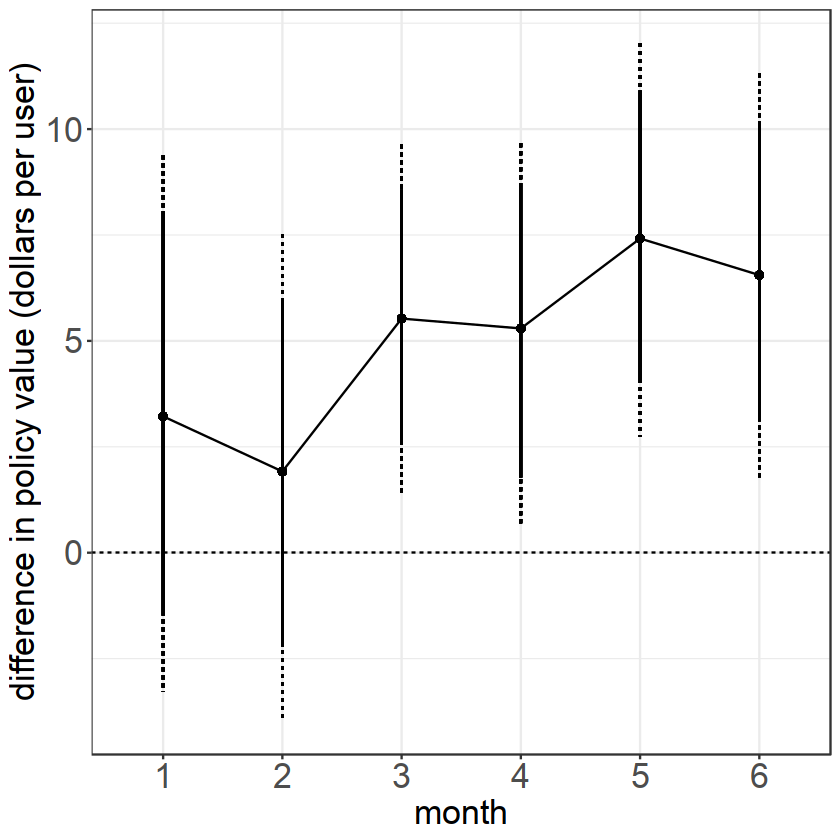

In [18]:
ggplot(ests_plot, aes(time,mean,group = 1)) + 
  geom_line() +
  geom_point() +
  geom_errorbar(aes(ymin=ci_95_lower, 
                    ymax=ci_95_upper), width=0, linetype = 'dashed') + 
  geom_errorbar(aes(ymin=ci_75_lower, 
                    ymax=ci_75_upper), width=0) + 
  theme_bw() + 
geom_hline(yintercept = 0, linetype = 'dashed') +
scale_x_discrete(limits = factor(c(1:6))) + 
scale_color_grey() +
xlab('month') + 
ylab('difference in policy value (dollars per user)') +
theme(axis.text = element_text(size = 20), axis.title = element_text(size = 20))   

### figure 3(c): comparing policy optimized on 1-6 month revenue with benchmark

In [19]:
mu_opt_6 = read.csv('mu_6m.csv') # outcome models trained to predict 6-month revenue
mu_opt_5 = read.csv('mu_5m.csv') # outcome models trained to predict 5-month revenue
mu_opt_4 = read.csv('mu_4m.csv') # outcome models trained to predict 4-month revenue
mu_opt_3 = read.csv('mu_3m.csv') # outcome models trained to predict 3-month revenue
mu_opt_2 = read.csv('mu_2m.csv') # outcome models trained to predict 2-month revenue
mu_opt_1 = read.csv('mu_1m.csv') # outcome models trained to predict 1-month revenue

mu_opt_6 = arrange(mu_opt_6, subscriber_id)
mu_opt_5 = arrange(mu_opt_5, subscriber_id)
mu_opt_4 = arrange(mu_opt_4, subscriber_id)
mu_opt_3 = arrange(mu_opt_3, subscriber_id)
mu_opt_2 = arrange(mu_opt_2, subscriber_id)
mu_opt_1 = arrange(mu_opt_1, subscriber_id)

In [20]:
obp_6 = optimize_binary_policy(mu_opt_6, df1, df1_s, 'subscriber_id', 'rev_m6', train_id) # optimize policy with 6-month revenue
obp_5 = optimize_binary_policy(mu_opt_5, df1, df1_s, 'subscriber_id', 'rev_m5', train_id) # optimize policy with 5-month revenue
obp_4 = optimize_binary_policy(mu_opt_4, df1, df1_s, 'subscriber_id', 'rev_m4', train_id) # optimize policy with 4-month revenue
obp_3 = optimize_binary_policy(mu_opt_3, df1, df1_s, 'subscriber_id', 'rev_m3', train_id) # optimize policy with 3-month revenue
obp_2 = optimize_binary_policy(mu_opt_2, df1, df1_s, 'subscriber_id', 'rev_m2', train_id) # optimize policy with 2-month revenue
obp_1 = optimize_binary_policy(mu_opt_1, df1, df1_s, 'subscriber_id', 'rev_m1', train_id) # optimize policy with 1-month revenue

In [21]:
pred = predict(obp_6, newdata = test[,1:ncol(df_X)]) %>% as.data.frame
test$response = pred$response
ests_6 = boot::boot(data = test, 
                  statistic = policy_eval_benchmark, 
                  R = 1000, 
                  parallel = "multicore",
                  ncpus = 4)

pred = predict(obp_5, newdata = test[,1:ncol(df_X)]) %>% as.data.frame
test$response = pred$response
ests_5 = boot::boot(data = test, 
                  statistic = policy_eval_benchmark, 
                  R = 1000, 
                  parallel = "multicore",
                  ncpus = 4)

pred = predict(obp_4, newdata = test[,1:ncol(df_X)]) %>% as.data.frame
test$response = pred$response
ests_4 = boot::boot(data = test, 
                  statistic = policy_eval_benchmark, 
                  R = 1000, 
                  parallel = "multicore",
                  ncpus = 4)

pred = predict(obp_3, newdata = test[,1:ncol(df_X)]) %>% as.data.frame
test$response = pred$response
ests_3 = boot::boot(data = test, 
                  statistic = policy_eval_benchmark, 
                  R = 1000, 
                  parallel = "multicore",
                  ncpus = 4)

pred = predict(obp_2, newdata = test[,1:ncol(df_X)]) %>% as.data.frame
test$response = pred$response
ests_2 = boot::boot(data = test, 
                  statistic = policy_eval_benchmark, 
                  R = 1000, 
                  parallel = "multicore",
                  ncpus = 4)

pred = predict(obp_1, newdata = test[,1:ncol(df_X)]) %>% as.data.frame
test$response = pred$response
ests_1 = boot::boot(data = test, 
                  statistic = policy_eval_benchmark, 
                  R = 1000, 
                  parallel = "multicore",
                  ncpus = 4)

In [22]:
ests_1 = as.data.frame(ests_1$t)
ests_2 = as.data.frame(ests_2$t)
ests_3 = as.data.frame(ests_3$t)
ests_4 = as.data.frame(ests_4$t)
ests_5 = as.data.frame(ests_5$t)
ests_6 = as.data.frame(ests_6$t)

ests_1$time = 1
ests_2$time = 2
ests_3$time = 3
ests_4$time = 4
ests_5$time = 5
ests_6$time = 6

ests = rbind(ests_1, ests_2, ests_3, ests_4, ests_5, ests_6)

In [23]:
ests_plot = ests %>% group_by(time) %>% mutate(mean = mean(V1),
                                               ci_75_lower = quantile(V1, 0.075),
                                               ci_75_upper = quantile(V1, 0.925),
                                               ci_95_lower = quantile(V1, 0.025),
                                               ci_95_upper = quantile(V1, 0.975))

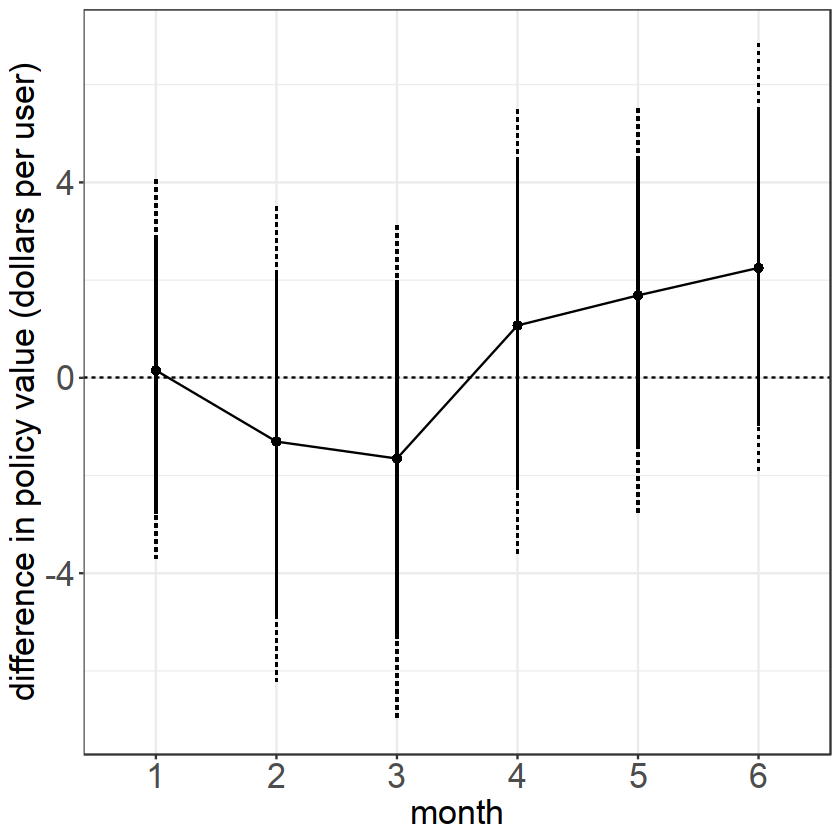

In [24]:
ggplot(ests_plot, aes(time,mean,group = 1)) + 
  geom_line() +
  geom_point() +
  geom_errorbar(aes(ymin=ci_95_lower, 
                    ymax=ci_95_upper), width=0, linetype = 'dashed') + 
  geom_errorbar(aes(ymin=ci_75_lower, 
                    ymax=ci_75_upper), width=0) + 
  theme_bw() + 
geom_hline(yintercept = 0, linetype = 'dashed') +
scale_x_discrete(limits = factor(c(1:6))) + 
scale_color_grey() +
xlab('month') + 
ylab('difference in policy value (dollars per user)') +
theme(axis.text = element_text(size = 20), axis.title = element_text(size = 20))   

### figure 3(d): comparing policy optimized on 18-month surrogate index with policy optimized on 18-month revenue

In [25]:
mu_opt_6 = read.csv('mu_18m_6.csv') # outcome models trained to predict surrogate index on 18-month revenue constructed with surrogates in the first 6 months
mu_opt_5 = read.csv('mu_18m_5.csv') # outcome models trained to predict surrogate index on 18-month revenue constructed with surrogates in the first 5 months
mu_opt_4 = read.csv('mu_18m_4.csv') # outcome models trained to predict surrogate index on 18-month revenue constructed with surrogates in the first 4 months
mu_opt_3 = read.csv('mu_18m_3.csv') # outcome models trained to predict surrogate index on 18-month revenue constructed with surrogates in the first 3 months
mu_opt_2 = read.csv('mu_18m_2.csv') # outcome models trained to predict surrogate index on 18-month revenue constructed with surrogates in the first 2 months
mu_opt_1 = read.csv('mu_18m_1.csv') # outcome models trained to predict surrogate index on 18-month revenue constructed with surrogates in the first 1 month

mu_opt_6 = arrange(mu_opt_6, subscriber_id)
mu_opt_5 = arrange(mu_opt_5, subscriber_id)
mu_opt_4 = arrange(mu_opt_4, subscriber_id)
mu_opt_3 = arrange(mu_opt_3, subscriber_id)
mu_opt_2 = arrange(mu_opt_2, subscriber_id)
mu_opt_1 = arrange(mu_opt_1, subscriber_id)

In [26]:
obp_6 = optimize_binary_policy(mu_opt_6, df1, df1_s, 'subscriber_id', 'rev_6', train_id) # optimize policy with 18-month surrogate index constructed with surrogates in the first 6 months
obp_5 = optimize_binary_policy(mu_opt_5, df1, df1_s, 'subscriber_id', 'rev_5', train_id) # optimize policy with 18-month surrogate index constructed with surrogates in the first 5 months
obp_4 = optimize_binary_policy(mu_opt_4, df1, df1_s, 'subscriber_id', 'rev_4', train_id) # optimize policy with 18-month surrogate index constructed with surrogates in the first 4 months
obp_3 = optimize_binary_policy(mu_opt_3, df1, df1_s, 'subscriber_id', 'rev_3', train_id) # optimize policy with 18-month surrogate index constructed with surrogates in the first 3 months
obp_2 = optimize_binary_policy(mu_opt_2, df1, df1_s, 'subscriber_id', 'rev_2', train_id) # optimize policy with 18-month surrogate index constructed with surrogates in the first 2 months
obp_1 = optimize_binary_policy(mu_opt_1, df1, df1_s, 'subscriber_id', 'rev_1', train_id) # optimize policy with 18-month surrogate index constructed with surrogates in the first 1 month

In [27]:
mu_opt_true = read.csv('mu_18m_true.csv') # outcome models trained to predict 18-month revenue
mu_opt_true = arrange(mu_opt_true, subscriber_id)

In [28]:
obp_true = optimize_binary_policy(mu_opt_true, df1, df1_s, 'subscriber_id', 'rev', train_id) # optimize policy with 18-month revenue

pred_true = predict(obp_true, newdata = test[,1:ncol(df_X)]) %>% as.data.frame
test$response_true = pred_true$response

In [29]:
pred = predict(obp_6, newdata = test[,1:ncol(df_X)]) %>% as.data.frame
test$response = pred$response
ests_6 = boot::boot(data = test, 
                  statistic = policy_eval_true, 
                  R = 1000, 
                  parallel = "multicore",
                  ncpus = 4)

pred = predict(obp_5, newdata = test[,1:ncol(df_X)]) %>% as.data.frame
test$response = pred$response
ests_5 = boot::boot(data = test, 
                  statistic = policy_eval_true, 
                  R = 1000, 
                  parallel = "multicore",
                  ncpus = 4)

pred = predict(obp_4, newdata = test[,1:ncol(df_X)]) %>% as.data.frame
test$response = pred$response
ests_4 = boot::boot(data = test, 
                  statistic = policy_eval_true, 
                  R = 1000, 
                  parallel = "multicore",
                  ncpus = 4)

pred = predict(obp_3, newdata = test[,1:ncol(df_X)]) %>% as.data.frame
test$response = pred$response
ests_3 = boot::boot(data = test, 
                  statistic = policy_eval_true, 
                  R = 1000, 
                  parallel = "multicore",
                  ncpus = 4)

pred = predict(obp_2, newdata = test[,1:ncol(df_X)]) %>% as.data.frame
test$response = pred$response
ests_2 = boot::boot(data = test, 
                  statistic = policy_eval_true, 
                  R = 1000, 
                  parallel = "multicore",
                  ncpus = 4)

pred = predict(obp_1, newdata = test[,1:ncol(df_X)]) %>% as.data.frame
test$response = pred$response
ests_1 = boot::boot(data = test, 
                  statistic = policy_eval_true, 
                  R = 1000, 
                  parallel = "multicore",
                  ncpus = 4)

In [30]:
ests_1 = as.data.frame(ests_1$t)
ests_2 = as.data.frame(ests_2$t)
ests_3 = as.data.frame(ests_3$t)
ests_4 = as.data.frame(ests_4$t)
ests_5 = as.data.frame(ests_5$t)
ests_6 = as.data.frame(ests_6$t)

ests_1$time = 1
ests_2$time = 2
ests_3$time = 3
ests_4$time = 4
ests_5$time = 5
ests_6$time = 6

ests = rbind(ests_1, ests_2, ests_3, ests_4, ests_5, ests_6)

In [31]:
ests_plot = ests %>% group_by(time) %>% mutate(mean = mean(V1),
                                               ci_75_lower = quantile(V1, 0.075),
                                               ci_75_upper = quantile(V1, 0.925),
                                               ci_95_lower = quantile(V1, 0.025),
                                               ci_95_upper = quantile(V1, 0.975))

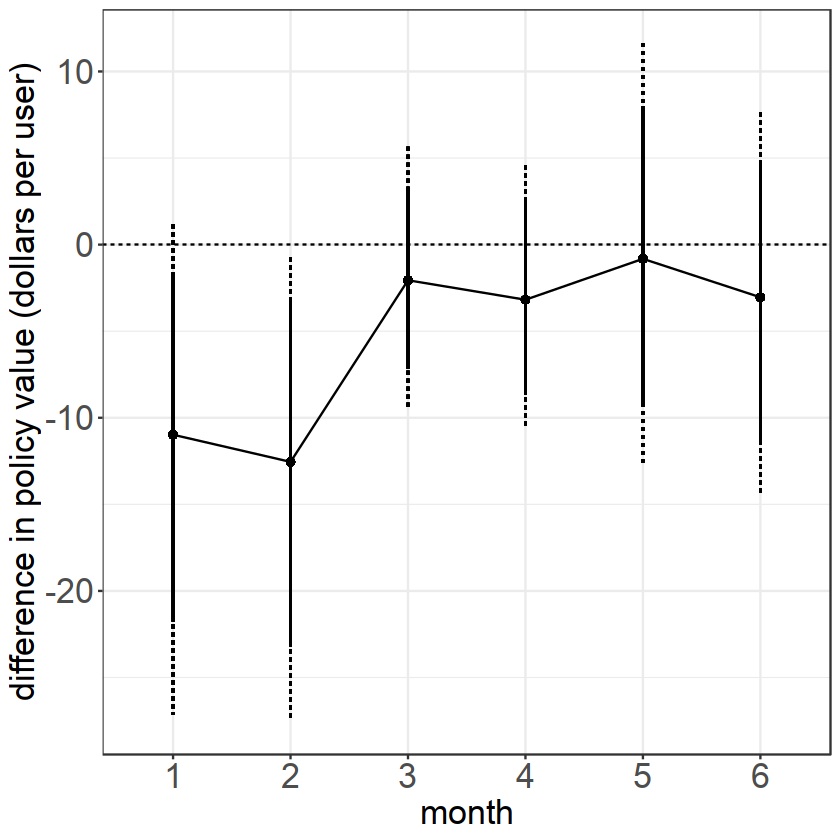

In [32]:
ggplot(ests_plot, aes(time,mean,group = 1)) + 
  geom_line() +
  geom_point() +
  geom_errorbar(aes(ymin=ci_95_lower, 
                    ymax=ci_95_upper), width=0, linetype = 'dashed') + 
  geom_errorbar(aes(ymin=ci_75_lower, 
                    ymax=ci_75_upper), width=0) + 
  theme_bw() + 
geom_hline(yintercept = 0, linetype = 'dashed') +
scale_x_discrete(limits = factor(c(1:6))) + 
scale_color_grey() +
xlab('month') + 
ylab('difference in policy value (dollars per user)') +
theme(axis.text = element_text(size = 20), axis.title = element_text(size = 20))   

### second experiment 

In [33]:
# load data from the second experiment 
df2 = read.csv('./df_exp2.csv')
df2_s = read.csv('./df_surrogate_exp2.csv')

df2 = arrange(df2, subscriber_id)
df2_s = arrange(df2_s, subscriber_id)

In [34]:
mu2 = read.csv('mu2_3y.csv')
mu2 = left_join(mu2, select(df2_s, subscriber_id, rev3), by = 'subscriber_id')
colnames(mu2)[9] = 'rev'

mu2 = left_join(mu2, select(df2,subscriber_id,condition,treated,prob), by = 'subscriber_id')

mu2$y0_dr = with(mu2, ifelse(condition == 'control', y0 + (rev-y0)/(1-prob), y0))
mu2$y1_dr = with(mu2, ifelse(condition == 'gift card', y1 + (rev-y1)/(prob/6), y1))
mu2$y2_dr = with(mu2, ifelse(condition == 'thank you email only', y2 + (rev-y2)/(prob/6), y2))
mu2$y3_dr = with(mu2, ifelse(condition == '$3.99/8 weeks', y3 + (rev-y3)/(prob/6), y3))
mu2$y4_dr = with(mu2, ifelse(condition == '$4.99/8 weeks', y4 + (rev-y4)/(prob/6), y4))
mu2$y5_dr = with(mu2, ifelse(condition == '$5.99/8 weeks', y5 + (rev-y5)/(prob/6), y5))
mu2$y6_dr = with(mu2, ifelse(condition == '$5.99/4 weeks', y6 + (rev-y6)/(prob/6), y6))

mu2 = arrange(mu2, subscriber_id)

In [35]:
cost2 = mu2[,13:19]
cost2$max = apply(cost2,1,max)
cost2 = apply(cost2,2,function(x) abs(x - cost2$max)) %>% as.data.frame
cost2$max = NULL

In [36]:
df2_x = select(df2, -c('subscriber_id',
                 'treated', 'churn', 'time', 'condition', 'prob', 'hte', 'action', 'score_c', 'rev1', 
                 'rev','subscription_status','score_discrete','last_stop_date'),
                  -contains('std'))
df2_X = model.matrix(~.-1, df2_x)
df2_X = as.data.frame(df2_X)
colnames(df2_X) = paste0('col',seq(1,ncol(df2_X)))

In [37]:
train2_id = sort(sample(nrow(df2_X), nrow(df2_X)*0.8))

In [38]:
omp = makeCostSensTask(id = "optimize multi-action policy", 
                       data = df2_X[train2_id,], 
                       cost = cost2[train2_id,])

learner = makeLearner("classif.xgboost",
                      predict.type = "prob",
                      eval_metric = 'logloss',
                      eta = 0.3,
                      max_depth = 6,
                      gamma = 0,
                      colsample_bytree = 0.6,
                      min_child_weight = 1,
                      subsample = 1,
                      nrounds = 150)
learner = makeCostSensWeightedPairsWrapper(learner)
    
omp = mlr::train(learner, omp)
pred = predict(omp, newdata = df2_X[-train_id,]) %>% as.data.frame

In [39]:
pred = pred %>% 
mutate(response = case_when(response == 'y0_dr' ~ 'control',
                      response == 'y1_dr' ~ 'gift card',
                      response == 'y2_dr' ~ 'thank you email only',
                      response == 'y3_dr' ~ '$3.99/8 weeks',
                      response == 'y4_dr' ~ '$4.99/8 weeks',
                      response == 'y5_dr' ~ '$5.99/8 weeks',
                      response == 'y6_dr' ~ '$5.99/4 weeks',
                     ))

In [40]:
# table 1: show classification on test data
table(pred$response)/nrow(pred)


       $3.99/8 weeks        $4.99/8 weeks        $5.99/4 weeks 
         0.002237389          0.003203168          0.274973441 
       $5.99/8 weeks              control            gift card 
         0.274297396          0.193670927          0.002527122 
thank you email only 
         0.249090558 